## get glm coefficients and correlations for publication
Update data in pipeline if needed.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Get data

In [2]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
date = data_fname.split('/')[-1][:-4].split('_')[1]

result_folder = 'results'

data_fname_glm_prefix = data_fname.split('/')[-1][:-4] + '_glm'
data_fname_glm_full = f'{result_folder}/{data_fname_glm_prefix}-full.csv'
data_fname_glm_baseline = f'{result_folder}/{data_fname_glm_prefix}-baseline.csv'

In [4]:
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())

### Covariates

In [5]:
covariates_baseline = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
]
covariates_full = covariates_baseline + ['risk_flu', 'urban_risk']

### standarize

In [6]:
df_z = df[steps_].copy()
for c in covariates_full:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.shape

(3094, 80)

## Functions

In [7]:
def glm(df, targets, cov, verbose=False):
    
    """
    """
    
    cors_cur, cors_nxt, r2_cur, r2_nxt, coef_dfs = [], [], [], [], []
    
    for i in range(len(targets)):
        cur = targets[i]
        formula = f'{cur}~{cov}'

        model = smf.glm(
            formula=formula,
            data=df,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        
        if verbose:
            print(f'{model.summary()}\n\n')

        prd = model.predict()
        cor_cur = pd.DataFrame(
            data={'prd': prd, 'grd': df[cur].values}, 
            index=df.index).corr().loc['prd', 'grd']
        cors_cur.append(cor_cur)
        r2_cur.append(r2_score(prd, df[cur].values))

        if i < len(targets) - 1:
            nxt = targets[i + 1]
            cor_nxt = pd.DataFrame(
                data={'prd': prd, 'grd': df[nxt].values}, 
                index=df.index).corr().loc['prd', 'grd']
            cors_nxt.append(cor_nxt)
            r2_nxt.append(r2_score(prd, df[nxt].values))

        # Get and save coefficients
        results_as_html = model.summary().tables[1].as_html()
        summary = pd.read_html(results_as_html, header=0, index_col=0)[0] 
        coef_dfs.append(summary[['coef']].rename(columns={'coef': cur}))
    
    cor_df = pd.concat([
        pd.DataFrame(data={'cor_cur': cors_cur}, index=steps),
        pd.DataFrame(data={'cor_nxt': cors_nxt}, index=steps[:-1])
    ], axis=1, join='outer')
    
    r2_df = pd.concat([
        pd.DataFrame(data={'r2_cur': r2_cur}, index=steps),
        pd.DataFrame(data={'r2_nxt': r2_nxt}, index=steps[:-1])
    ], axis=1, join='outer')
    
    coef_df = pd.concat(coef_dfs, axis=1).rename(columns={t: s for t, s in zip(targets, steps)}).T
    coef_df.index.name = 'date'
    
    return cor_df, r2_df, coef_df

# Full GLM

In [8]:
df_full = df_z.copy()
cov_full = '+'.join(covariates_full)

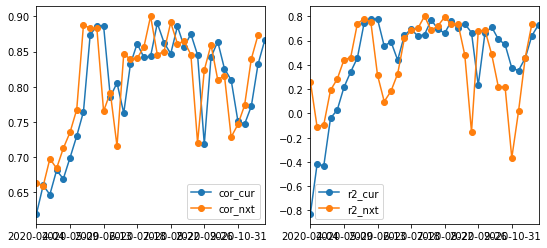

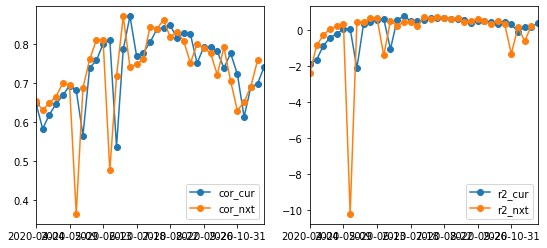

In [9]:
for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

    cor_df, r2_df, coef_df = glm(df_full, targets, cov_full)
    
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    cor_df.plot(ax=axes[0], marker='o')
    axes[0].legend()
    r2_df.plot(ax=axes[1], marker='o')
    axes[1].legend()

    coef_df.to_csv(f'{result_folder}/{target_type}/{date}_coef_full.csv', float_format='%.5f')
    cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor_full.csv', float_format='%.5f')
    r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2_full.csv', float_format='%.5f')

df_full.to_csv(data_fname_glm_full, float_format='%.2f')

## Baseline GLM

In [10]:
df_baseline = df_z.copy()
cov_baseline = '+'.join(covariates_baseline)

(3094, 80)


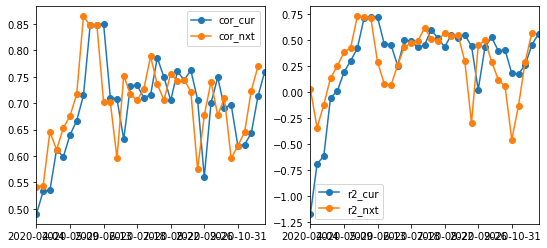

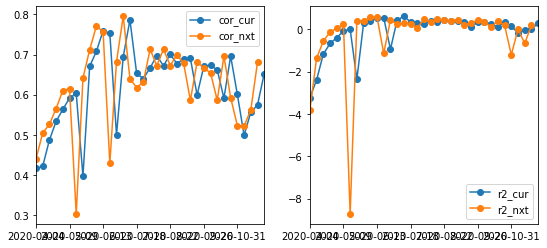

In [11]:
for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

    cor_df, r2_df, coef_df = glm(df_baseline, targets, cov_baseline)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    cor_df.plot(ax=axes[0], marker='o')
    axes[0].legend()
    r2_df.plot(ax=axes[1], marker='o')
    axes[1].legend()

    coef_df.to_csv(f'{result_folder}/{target_type}/{date}_coef_baseline.csv', float_format='%.5f')
    cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor_baseline.csv', float_format='%.5f')
    r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2_baseline.csv', float_format='%.5f')

df_baseline.to_csv(data_fname_glm_baseline, float_format='%.2f')
print(df_baseline.shape)

# Combine correlation of full and baseline

In [12]:
for target_type in ['case', 'death']:

    cor_full_fname = f'{result_folder}/{target_type}/{date}_cor_full.csv'
    cor_full = pd.read_csv(cor_full_fname, index_col=0)
    cor_full = cor_full.rename(columns={col: col + '_full' for col in cor_full.columns})

    cor_baseline_fname = f'{result_folder}/{target_type}/{date}_cor_baseline.csv'
    cor_baseline = pd.read_csv(cor_baseline_fname, index_col=0)
    cor_baseline = cor_baseline.rename(columns={col: col + '_baseline' for col in cor_baseline.columns})

    cor_df = pd.concat([cor_full, cor_baseline], axis=1)
    cor_df.index.name = 'date'
    cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor.csv', float_format='%.5f')

In [13]:
for target_type in ['case', 'death']:

    r2_full_fname = f'{result_folder}/{target_type}/{date}_r2_full.csv'
    r2_full = pd.read_csv(r2_full_fname, index_col=0)
    r2_full = r2_full.rename(columns={col: col + '_full' for col in r2_full.columns})

    r2_baseline_fname = f'{result_folder}/{target_type}/{date}_r2_baseline.csv'
    r2_baseline = pd.read_csv(r2_baseline_fname, index_col=0)
    r2_baseline = r2_baseline.rename(columns={col: col + '_baseline' for col in r2_baseline.columns})

    r2_df = pd.concat([r2_full, r2_baseline], axis=1)
    r2_df['r2_diff'] = r2_df['r2_cur_full'] - r2_df['r2_cur_baseline']
    r2_df.index.name = 'date'
    r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2.csv', float_format='%.5f')